<a href="https://colab.research.google.com/github/Viliuskerutis/AML/blob/main/AML_MP2_Kerutis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MP2: Deep Fast Fashion

Date: 2020.11.23

Author: © 2020 [Vilius Kerutis](vilius.kerutis@ktu.edu)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

The goal of this work is to create a deep learning model using [PyTorch](https://pytorch.org/), that is trained in under 3 minutes in [Google Colab](https://colab.research.google.com/) environment on [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) data, gives the best possible testing performance. 

This template is partially based on [this solution](
https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d). 

You should select GPU in Google Colab: *Runtime -> Change runtime type -> Hardware accelerator: GPU*.

The performance will be measured on *Tesla P100* graphics card which is the most popular in Google Colab machines, but you will not always get a machine with this GPU. Other GPUs: Tesla P4, Tesla T4 are similar in performance to P100 (slightly faster on average), and K80 is slower. The speed also varies slightly based on other factors, like the Colab cloud usage load.

You should only eddit this notebook where it is allowed, comment on all of your improvements in markdown cells and in your presentation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

## Settings

Do not eddit!

On the reproducibility of experiments: https://pytorch.org/docs/stable/notes/randomness.html

In [2]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 1.0*corrects / batch_size
    return accuracy.item()
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Information on the obtained hardware

In [3]:
print('Torch version: %s' %torch.__version__)
if torch.cuda.is_available():
    print('GPU: %s' %torch.cuda.get_device_name()) 
else:
    print('GPU not available.')

Torch version: 1.7.0+cu101
GPU: Tesla T4


In [4]:
!nvidia-smi

Mon Nov 23 18:24:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

## Import the data

You can change the data transformations but not the splitting (50000:10000) between training and validation in this notebook. But you can use a different type of validation with this data in our other codes to find the best model and its hyper-parameters, as long as you don't touch testing data. 

In [6]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
# do not change this!
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainset, validset = torch.utils.data.random_split(dataset, [50000,10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

len(trainset), len(validset)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(50000, 10000)

### Show a couple of data points

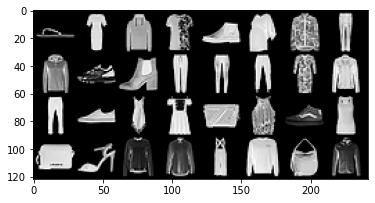

In [7]:
import matplotlib.pyplot as plt

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

## Report of the things tried and their validation results

First of all, I worked with different models - not PyTorch. I got difficult to adapt those models into this template, and the score was really low. I think that the gap between my knowledge of ML, Python, and valuable information on the internet was too big. I tried all the solutions in these links (exact codes scraps I was working with are provided into .zip file):

https://www.geeksforgeeks.org/best-python-libraries-for-machine-learning/

https://www.upgrad.com/blog/top-python-libraries-for-machine-learning/

https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/

https://www.tensorflow.org/tutorials/keras/regression

https://towardsdatascience.com/linear-regression-with-python-and-numpy-25d0e1dd220d

https://towardsdatascience.com/end-to-end-python-framework-for-predictive-modeling-b8052bb96a78


Finally, I gave up on other online solutions and tried to find the perfect parameters for the given model. I tried a lot of different methods to get the highest training score and here are the result of my experiment (here I show only the results which has a training score higher than 0.900):

| Model | Training accuracy | Validation accuracy | Loss|
|-------|-------------------|---------------------|-----|
|Default|       0.931       |        0.8915       |     |
| Gelu  |       0.9011      |        0.8748       |     |
|ReluxGelu|     0.9304| 0.8945||
|Logsigmoid|0.9925|0.9020| 0.0202|
|Log_softmax|0.9947|0.9048|0.0140|

As you can see from the given results table, the highest training performance was reached with the Log_softmax method and 16 epochs. Another great performance was reached with the Logsigmoid method and 16 epochs. The training score difference between these two methods was only 0.0022. I felt that the highest score might be achieved using methods that are related to logarithms.

## Creation of the best model

Here I tried to choose the correct parameters to get the highest training score, and this is my best shot! At the output, I am using the log_softmax method, and it gives the best result for me. I also tried to use relu, gelu, logsigmoid, linear, and some other methods there. The same methods were used instead of relu in this code.

In [8]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.log_softmax(logits)
        return out

### Learning parameters

Here I changed the `num_epochs` parameter to get the highest score on the last epoch. Sixteen epochs fit into three minutes and give the best score. Also, I have tried different `learning_rate` values. I tested that the perfect learning rate is equal to 0.001 with given model parameters.

In [9]:
learning_rate = 0.001
num_epochs = 16

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train

Do not edit! The training is only happening here.

In [10]:
# timing. do not alter!
start_timer = torch.cuda.Event(enable_timing=True)
end_timer = torch.cuda.Event(enable_timing=True)
start_timer.record()

# training stats
trainlosses = np.zeros(num_epochs)
trainaccs = np.zeros(num_epochs)
validaccs = np.zeros(num_epochs)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    train_running_loss /= len(trainloader)
    train_acc /= len(trainloader)

    valid_acc = 0.0
    for i, (images, labels) in enumerate(validloader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        valid_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    valid_acc /= len(validloader)

    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f | Validation Accuracy: %.4f' \
          %(epoch, train_running_loss, train_acc, valid_acc)) 
            
    trainlosses[epoch] = train_running_loss
    trainaccs[epoch] = train_acc
    validaccs[epoch] = valid_acc

# timing. do not alter!
end_timer.record()
torch.cuda.synchronize()
elapsed_time = start_timer.elapsed_time(end_timer)
max_training_time = 3*60*1000
print('Training time: %.2f ms (max %i ms.)' %(elapsed_time,max_training_time))  
assert elapsed_time <= max_training_time, 'Training is too long!'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0 | Loss: 0.4029 | Train Accuracy: 0.8555 | Validation Accuracy: 0.8735
Epoch: 1 | Loss: 0.2594 | Train Accuracy: 0.9037 | Validation Accuracy: 0.8968
Epoch: 2 | Loss: 0.2020 | Train Accuracy: 0.9242 | Validation Accuracy: 0.9003
Epoch: 3 | Loss: 0.1572 | Train Accuracy: 0.9409 | Validation Accuracy: 0.9069
Epoch: 4 | Loss: 0.1224 | Train Accuracy: 0.9542 | Validation Accuracy: 0.9044
Epoch: 5 | Loss: 0.0934 | Train Accuracy: 0.9654 | Validation Accuracy: 0.9062
Epoch: 6 | Loss: 0.0736 | Train Accuracy: 0.9733 | Validation Accuracy: 0.9049
Epoch: 7 | Loss: 0.0555 | Train Accuracy: 0.9798 | Validation Accuracy: 0.9008
Epoch: 8 | Loss: 0.0455 | Train Accuracy: 0.9835 | Validation Accuracy: 0.8983
Epoch: 9 | Loss: 0.0359 | Train Accuracy: 0.9870 | Validation Accuracy: 0.8956
Epoch: 10 | Loss: 0.0313 | Train Accuracy: 0.9890 | Validation Accuracy: 0.9003
Epoch: 11 | Loss: 0.0234 | Train Accuracy: 0.9916 | Validation Accuracy: 0.9045
Epoch: 12 | Loss: 0.0209 | Train Accuracy: 0.9924 

Plot training loss, training and validation accuracy over training epochs.

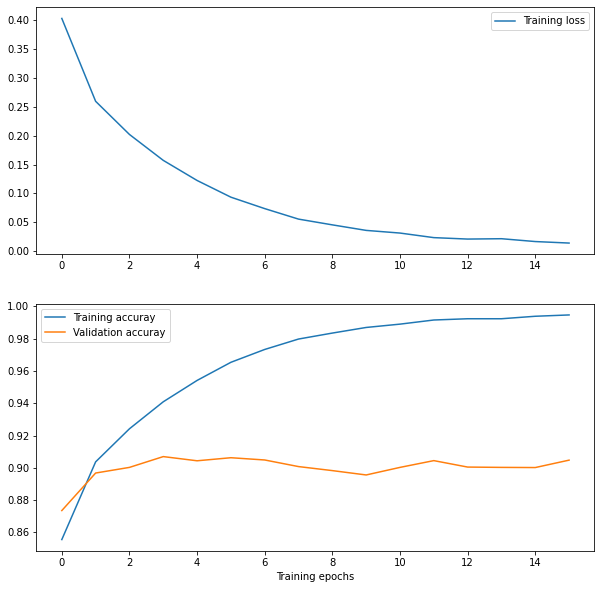

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(trainlosses)
plt.legend(['Training loss']) 
plt.subplot(2,1,2)
plt.plot(trainaccs)
plt.plot(validaccs)
plt.xlabel('Training epochs')
plt.legend(['Training accuray','Validation accuray'])